# Zee: Zero Effort Crowdsourcing for Indoor Localization

This notebook implements the algorithm described in the Zee paper.

In [1]:
from dataclasses import dataclass

In [12]:
import numpy as np
import pandas as pd
import os
import sys
import json
import shapely
import sklearn
import scipy
import shapely.vectorized
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon
from shapely import ops as shapely_ops

%matplotlib inline

In [13]:
PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(
    PROJECT_HOME, "code", "indoor-location-competition-20"
)
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

The library is located at ./../../code/indoor-location-competition-20


In [14]:
# type: ignore
from compute_f import split_ts_seq, compute_step_positions
from io_f import read_data_file
from visualize_f import visualize_trajectory, visualize_heatmap, save_figure_to_html

In [15]:
CODE_DIR = os.path.join(PROJECT_HOME, "code")
print(f"The code is located in {CODE_DIR}")
sys.path.append(CODE_DIR)

The code is located in ./../../code


In [88]:
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale

In [18]:
from pathlib import Path

In [23]:
from glob import glob

## Read Train/Test Assignment

In [17]:
train_test_assignment = pd.read_csv("../../data/output/train_test_assignment.csv")
train_test_assignment["site_id"] = train_test_assignment["site_id"].astype("category")
train_test_assignment["floor_id"] = train_test_assignment["floor_id"].astype("category")
train_test_assignment["dataset"] = train_test_assignment["dataset"].astype("category")

## Context Definition

Define Zee context, which includes
  * Paths to train track data./
  * Floor map description.

In [33]:
site_id = "5da138b74db8ce0c98bd4774"
floor_id = "B1"

path_data_dir = Path(f"../../data/train")

In [34]:
train_tracks = train_test_assignment[
    (train_test_assignment["site_id"] == site_id) 
    & (train_test_assignment["floor_id"] == floor_id)
    & (train_test_assignment["dataset"] == "train")]

In [35]:
def get_track_filepaths(assignment_df: pd.DataFrame, base_data_dir: str | Path, suffix: str) -> list[str]:
  if isinstance(base_data_dir, str):
    base_data_dir = Path(base_data_dir)
    
  result = []

  for _, row in assignment_df.iterrows():
    file_path = base_data_dir / row["site_id"] / row["floor_id"] / (str(row["track_id"]) + suffix)
    if not os.path.exists(file_path):
      print(f"File {file_path} does not exist.")
      continue
    result.append(file_path)
    
  return result

In [36]:
train_files = get_track_filepaths(train_tracks, path_data_dir, suffix=".txt")

In [38]:
# Reading floor map data
floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

### Floormap Extraction

In [39]:
transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

## Reading Path Data

In [40]:
path_datas = read_data_file(train_files[0])

In [41]:
acce_datas = path_datas.acce
magn_datas = path_datas.magn
ahrs_datas = path_datas.ahrs
wifi_datas = path_datas.wifi
ibeacon_datas = path_datas.ibeacon
posi_datas = path_datas.waypoint

In [42]:
gt_times = path_datas.waypoint[:, 0]
gt_location = path_datas.waypoint[:, 1:]

## Zee: Counting Steps

In [43]:
ts = path_datas.acce[:, 0].astype(np.int64)

acce_x = path_datas.acce[:, 1]
acce_y = path_datas.acce[:, 2]
acce_z = path_datas.acce[:, 3]

# a = sqrt(ax*ax + ay*ay + az*az)
acce = np.sqrt(np.sum(path_datas.acce[:, 1:] ** 2, axis=1))

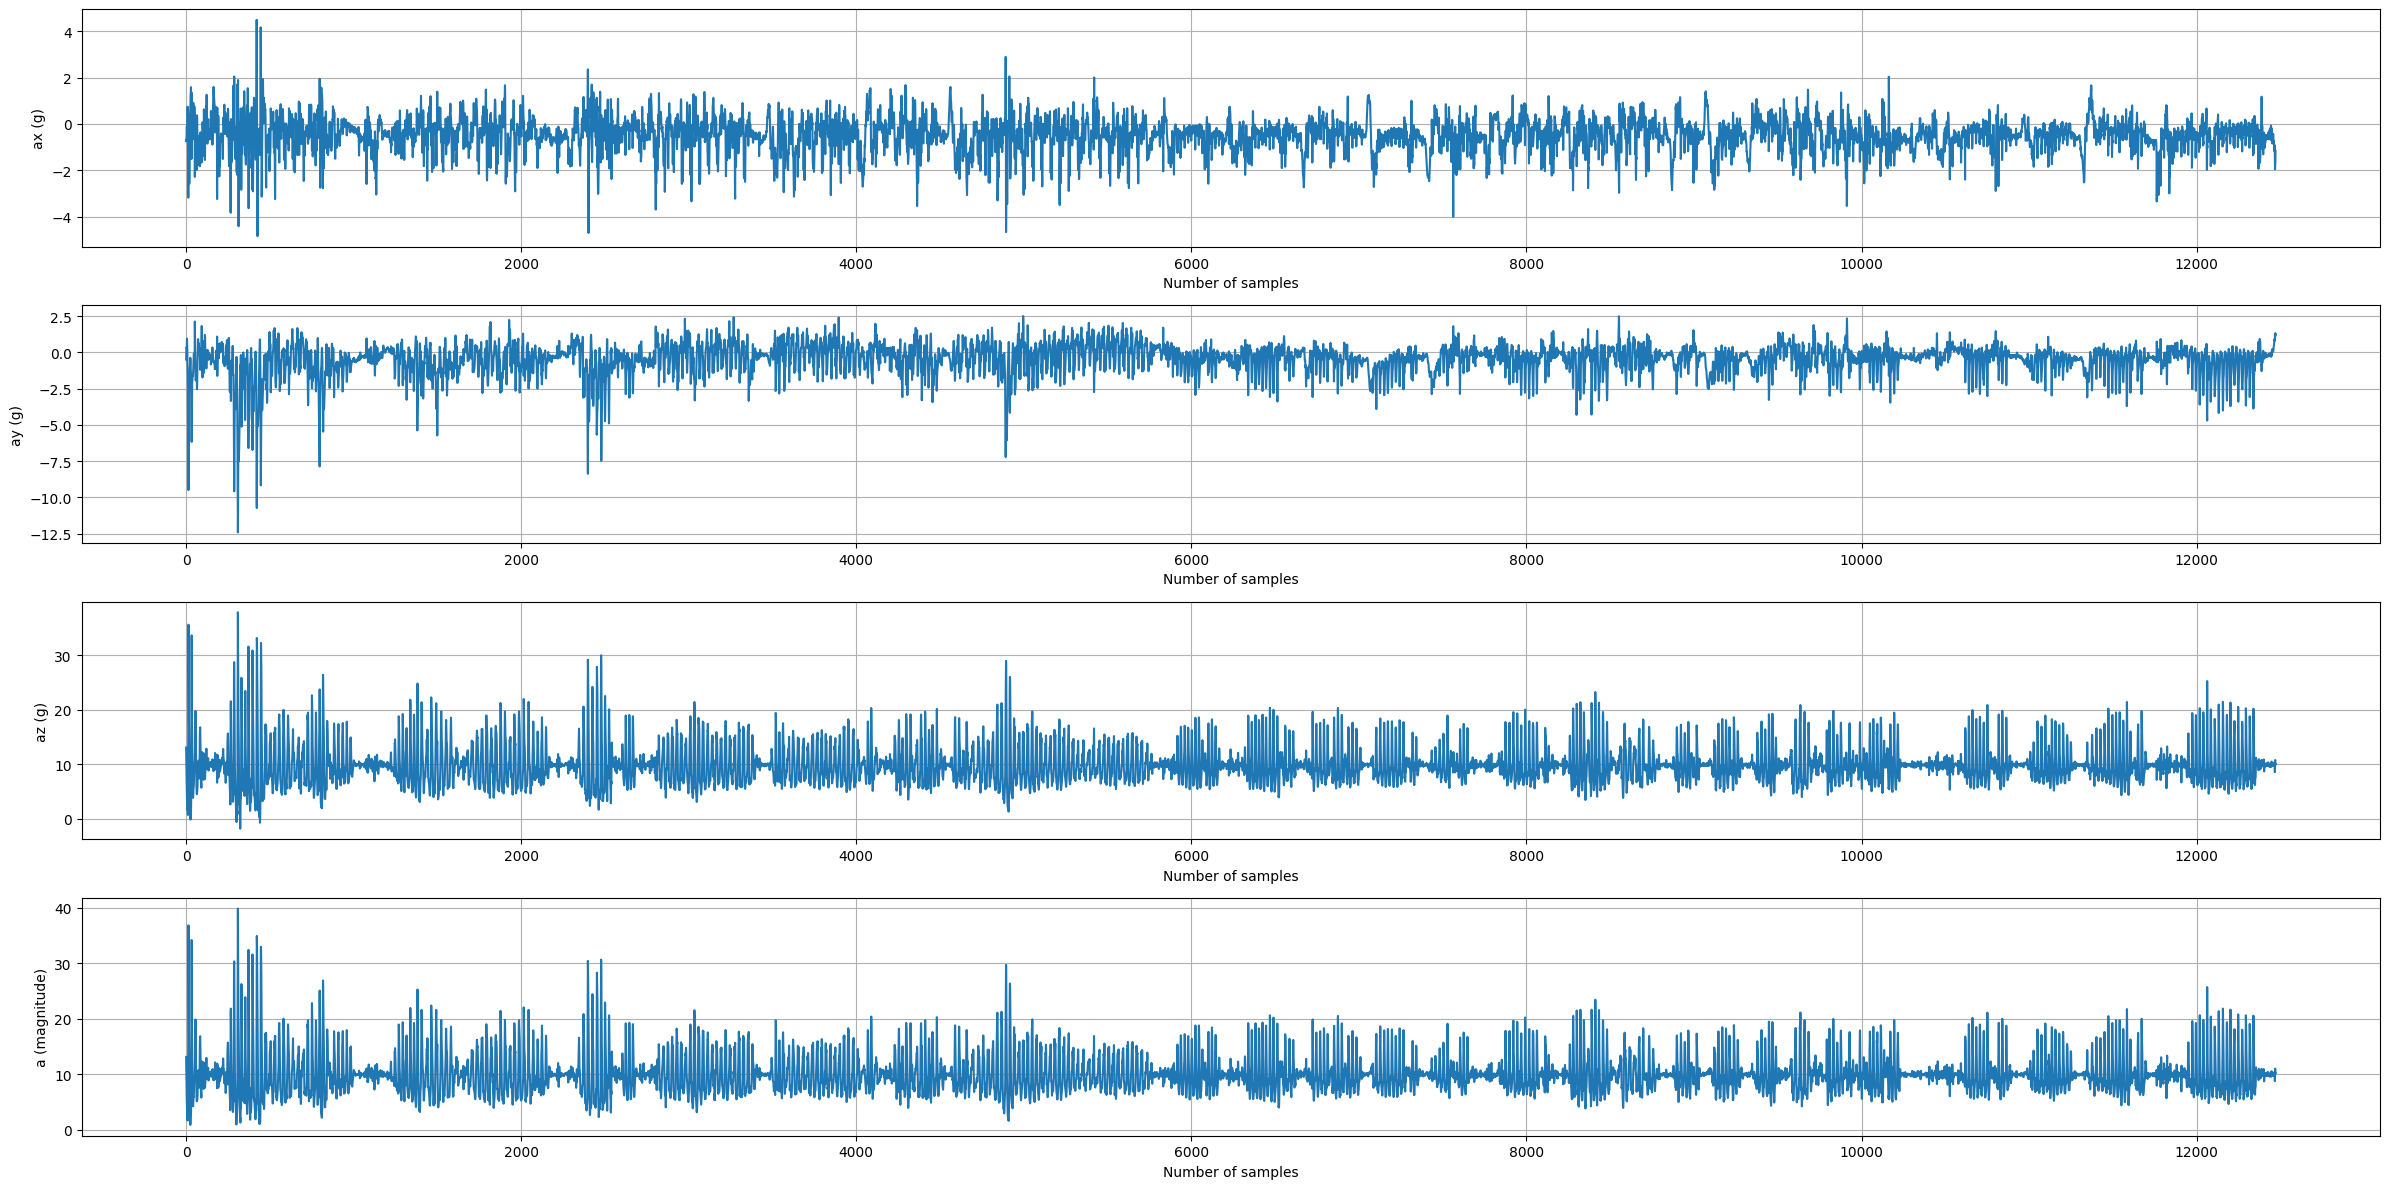

In [45]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=(24, 12),
)

ax1.plot(acce_x)
ax1.set_ylabel("ax (g)")
ax1.set_xlabel("Number of samples")

ax2.plot(acce_y)
ax2.set_ylabel("ay (g)")
ax2.set_xlabel("Number of samples")

ax3.plot(acce_z)
ax3.set_ylabel("az (g)")
ax3.set_xlabel("Number of samples")

ax4.plot(acce)
ax4.set_ylabel("a (magnitude)")
ax4.set_xlabel("Number of samples")

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

plt.tight_layout()
plt.show()

### Applying Low-pass Filter

In [46]:
def low_pass_filter(acc, alpha):
  n = len(acc)
  f_acc = np.zeros_like(acc)
  f_acc[0] = acc[0]
  for i in range(1, n):
    f_acc[i] = alpha * f_acc[i - 1] + (1 - alpha) * acc[i]
  return f_acc


def high_pass_filter(acc, alpha):
  n = len(acc)
  f_acc = np.zeros_like(acc)
  f_acc[0] = acc[0]
  for i in range(1, n):
    f_acc[i] = alpha * f_acc[i - 1] + alpha * (acc[i] - acc[i - 1])
  return f_acc


In [47]:
hpf = high_pass_filter(acce, alpha=0.98)

In [49]:
def filter_and_plot_signal(signal, sampling_freq, figsize=(18, 6)):
  alpha = 1.0 / (1.0 + 1.0 / sampling_freq)
  lpf = low_pass_filter(signal, alpha=alpha)
  hpf = high_pass_filter(signal, alpha=alpha)

  fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=figsize)

  ax.plot(signal, label="original")
  ax.plot(lpf, label="low-pass", color="red")
  ax.plot(hpf, label="high-pass", color="green")
  ax.set_ylabel("signal")
  ax.set_xlabel("Number of samples")
  ax.legend()

  plt.tight_layout()
  plt.show()


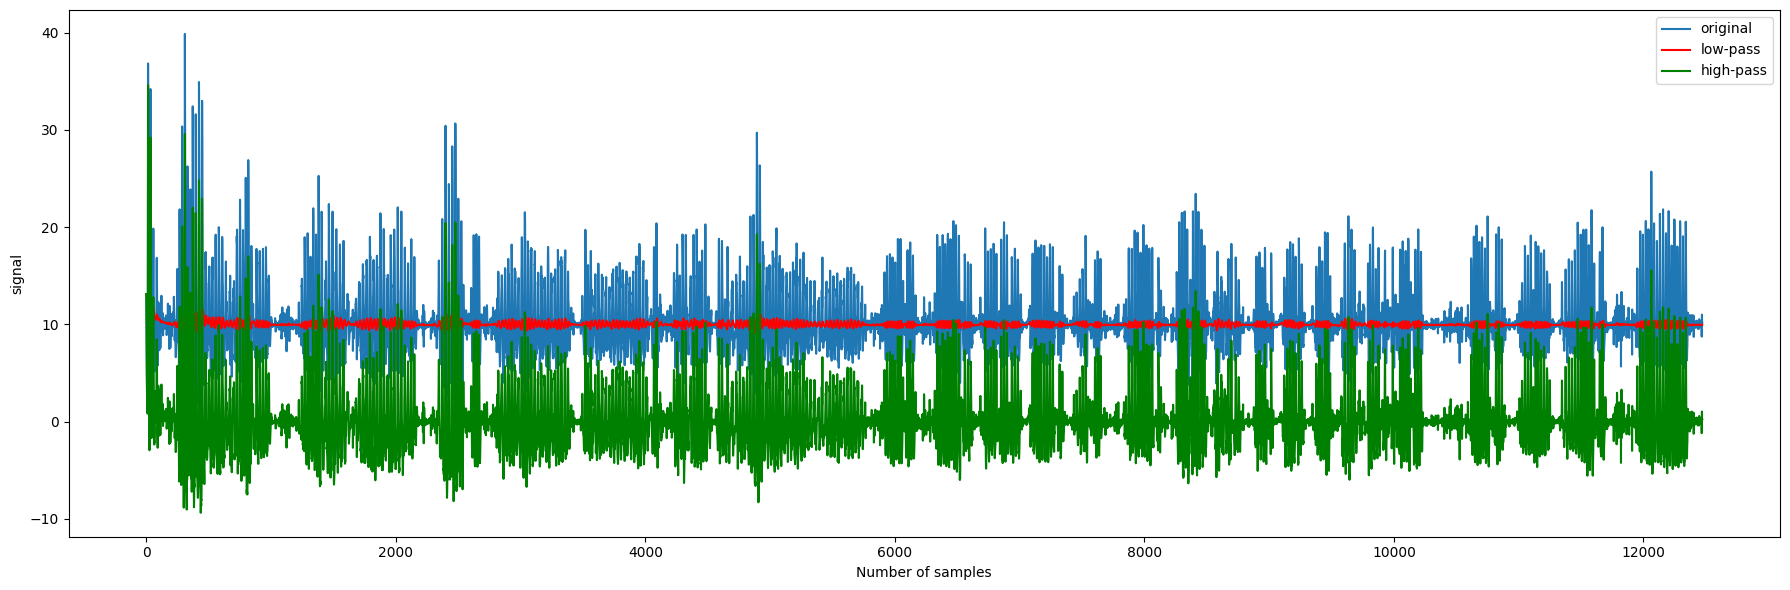

In [50]:
filter_and_plot_signal(signal=acce, sampling_freq=50)

### Normalized Auto-correlation based Step Counting (NASC)

* The intuition behind NASC is that if the user is walking, then the auto-correlation will spike at the correct periodicity of the walker.

In [52]:
def norm_acf(a, m, t):
  mu_m, sigma_m = np.mean(a[m:m + t], axis=0), np.std(a[m:m + t], axis=0)
  mu_mt, sigma_mt = np.mean(a[m + t:m + t * 2],
                            axis=0), np.std(a[m + t:m + t * 2], axis=0)

  n_acf = (np.sum((a[m:m + t] - mu_m) * (a[m + t:m + t * 2] - mu_mt), axis=0) /
           t / sigma_m / sigma_mt)

  return np.mean(n_acf)


In [53]:
acc_sampling_freq = ts.shape[0] / (ts[-1] / 1000 - ts[0] / 1000)
print("The sampling frequency of accelerometer is {:.2f}Hz".format(acc_sampling_freq))

The sampling frequency of accelerometer is 50.36Hz


In [54]:
def max_norm_acf(a, m, t_min=40, t_max=100):
  """
  Finding the maximum normalized auto-correlation.
  """
  t_best = t_min
  n_acf_best = norm_acf(a, m, t_best)
  for t in range(t_min, t_max + 1):
    n_acf = norm_acf(a, m, t)
    if n_acf > n_acf_best:
      t_best = t
      n_acf_best = n_acf
  return n_acf_best, t_best


In [55]:
STATE_IDLE = "IDLE"
STATE_WALKING = "WALKING"


def get_state(acce, m, prev_state=None, prev_t_opt=None):
  if prev_t_opt is not None:
    t_min, t_max = max(40, prev_t_opt - 10), min(100, prev_t_opt + 10)
  else:
    t_min, t_max = 40, 100

  n_acf, t_opt = max_norm_acf(acce, m=m, t_min=t_min, t_max=t_max)

  sigma = np.mean(np.std(acce[m:m + t_opt], axis=0))
  if sigma < 0.01:
    return STATE_IDLE, t_opt

  if n_acf > 0.7:
    return STATE_WALKING, t_opt

  return prev_state, t_opt


In [56]:
get_state(acce, m=50)

(None, 49)

## Zee: Estimating Heading Offset Range

### Estimating Heading

* Heading is the $\theta$ from the paper, which is the compass value.

In [57]:
def get_rotation_matrix(gravity, geomagnetic, R):
  """
  https://android.googlesource.com/platform/frameworks/base/+/master/core/java/android/hardware/SensorManager.java
  """
  ax = gravity[0]
  ay = gravity[1]
  az = gravity[2]

  norm_sq_a = ax * ax + ay * ay + az * az
  g = 9.81

  free_fall_gravity_squared = 0.01 * g * g

  if norm_sq_a < free_fall_gravity_squared:
    # gravity is less than 10% of normal value
    return False

  ex = geomagnetic[0]
  ey = geomagnetic[1]
  ez = geomagnetic[2]
  hx = ey * az - ez * ay
  hy = ez * ax - ex * az
  hz = ex * ay - ey * ax

  norm_h = np.sqrt(hx * hx + hy * hy + hz * hz)

  if norm_h < 0.1:
    # device is close to free fall, or close to magnetic north pole, typical values are > 100
    return False

  inv_h = 1.0 / norm_h
  hx *= inv_h
  hy *= inv_h
  hz *= inv_h

  inv_a = 1.0 / np.sqrt(norm_sq_a)
  ax *= inv_a
  ay *= inv_a
  az *= inv_a
  mx = ay * hz - az * hy
  my = az * hx - ax * hz
  mz = ax * hy - ay * hx

  if R is not None:
    if len(R) == 9:
      R[0] = hx
      R[1] = hy
      R[2] = hz
      R[3] = mx
      R[4] = my
      R[5] = mz
      R[6] = ax
      R[7] = ay
      R[8] = az
    elif len(R) == 16:
      R[0] = hx
      R[1] = hy
      R[2] = hz
      R[3] = 0
      R[4] = mx
      R[5] = my
      R[6] = mz
      R[7] = 0
      R[8] = ax
      R[9] = ay
      R[10] = az
      R[11] = 0
      R[12] = 0
      R[13] = 0
      R[14] = 0
      R[15] = 1

  return True


In [58]:
def get_orientation(R, values):
  """
  values[0]: azimuth
  values[1]: pitch
  values[2]: roll
  """
  if len(R) == 9:
    values[0] = np.arctan2(R[1], R[4])
    values[1] = np.arcsin(-R[7])
    values[2] = np.arctan2(-R[6], R[8])
  else:
    values[0] = np.arctan2(R[1], R[5])
    values[1] = np.arcsin(-R[9])
    values[2] = np.arctan2(-R[8], R[10])

  return values


In [59]:
R = np.zeros(9, dtype=np.float64)
orientation = np.zeros(3, dtype=np.float64)
gravity = path_datas.acce[0, 1:]
geomagnetic = path_datas.magn[0, 1:]

result = get_rotation_matrix(gravity, geomagnetic, R)
if result:
  get_orientation(R, orientation)
  theta = np.degrees(orientation[0])
  print(f"theta={theta:.2f}")


theta=95.87


In [60]:
# Heading and acceleration (w.r.t. earth coordinate system) estimation

n = len(path_datas.acce)

heading_values = np.zeros(n, dtype=np.float32)
acce_earths = np.zeros((n, 3), dtype=np.float32)

R = np.zeros(9, dtype=np.float64)
orientation = np.zeros(3, dtype=np.float64)

for i in range(n):
  result = get_rotation_matrix(path_datas.acce[i, 1:], path_datas.magn[i, 1:],
                               R)
  if result:
    get_orientation(R, orientation)
    heading_values[i] = np.degrees(orientation[0])

    inv_R = np.linalg.inv(R.reshape(3, 3))
    acce_earths[i, :] = np.matmul(inv_R, path_datas.acce[i, 1:])
  else:
    heading_values[i] = heading_values[i - 1]
    acce_earths[i, :] = acce_earths[i - 1, :]


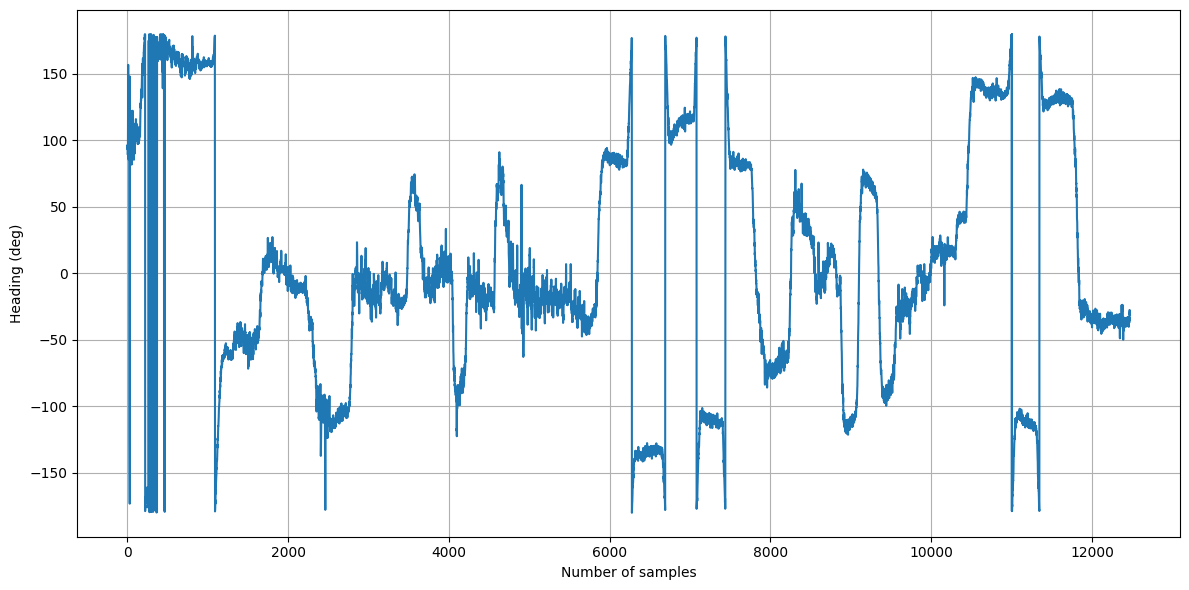

In [61]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

ax.plot(heading_values, label="heading")
ax.set_ylabel("Heading (deg)")
ax.set_xlabel("Number of samples")
ax.grid()

plt.tight_layout()
plt.show()

### Spectrum of a Typical Walk

* After observing the Fourier transform across several uses and placements, the authors discovered an interesting fact: *the second harmonic is either completely absent or is extremely weak in the accelerations experienced by the phone in the direction perpendicular to the user's walk. It is however always present and dominant in the direction parallel to the user's walk.*
* What are implications of this observation? - We can estimate the possible values for the sum `magnetic_offset + heading_offset + compass` from the magnitude of the second harmonic in teh Fourier transform along north `Fy` and along west `Fx`
  * `magnetic_offset + heading_offset + compass = arctan(Fx/Fy)`
  * OR `magnetic_offset + heading_offset + compass = arctan(Fx/Fy) + 180`

In [62]:
def show_spectrum(signal_data, fs, figsize=(10, 6), ax1=None, ax2=None):
  n_samples = len(signal_data)
  duration = n_samples / fs
  t = np.linspace(0, duration, int(fs * duration), endpoint=False)

  frequencies, spectrum = scipy.signal.periodogram(signal_data, fs=fs)

  if ax1 is None and ax2 is None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

  ax1.plot(t, signal_data)
  ax1.set_xlabel("Time (s)")
  ax1.set_ylabel("Amplitude")
  ax1.set_title("Time Domain Signal")

  ax2.plot(frequencies, spectrum)
  ax2.set_xlabel("Frequency (Hz)")
  ax2.set_ylabel("Magnitude")
  ax2.set_title("Frequency Spectrum")

  plt.tight_layout()


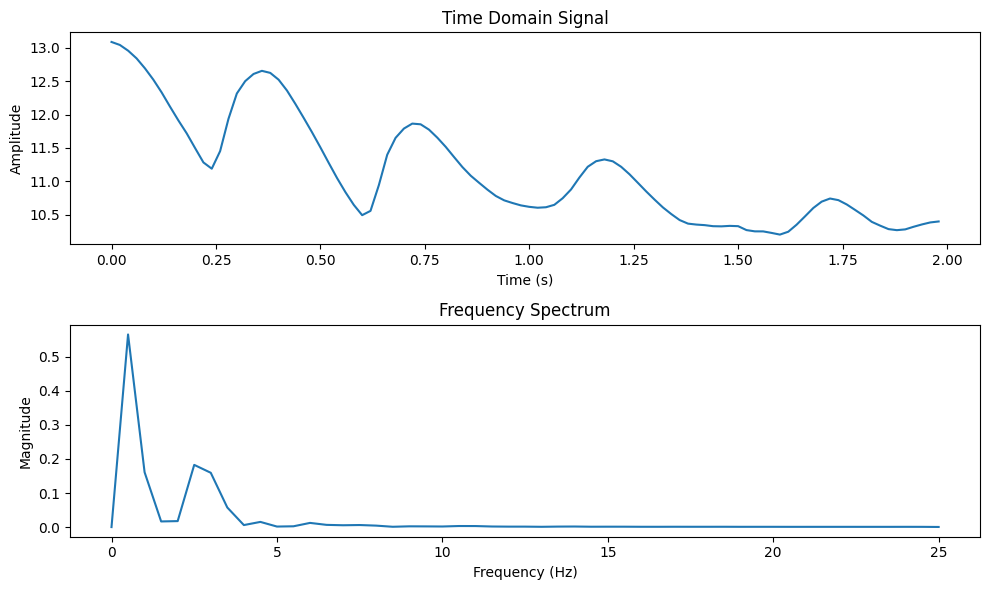

In [63]:
show_spectrum(low_pass_filter(acce_z[0:100], alpha=0.98), fs=50)

In [64]:
def find_fundamental_frequency(frequencies, spectrum):
  idx = np.argmax(spectrum)
  return frequencies[idx], spectrum[idx]


In [65]:
def find_fundamental_frequency_and_harmonics(frequencies,
                                             spectrum,
                                             harmonics=(2, 3, 4)):
  fundamental_frequency, amplitude = find_fundamental_frequency(
      frequencies, spectrum)
  harmonics_found = [
      harmonic for harmonic in harmonics
      if harmonic * fundamental_frequency in frequencies
  ]
  return fundamental_frequency, amplitude, harmonics_found


Fundamental Frequency: 2.2 Hz, Magnitude: 83.23
Harmonics Found: [2, 3, 4]


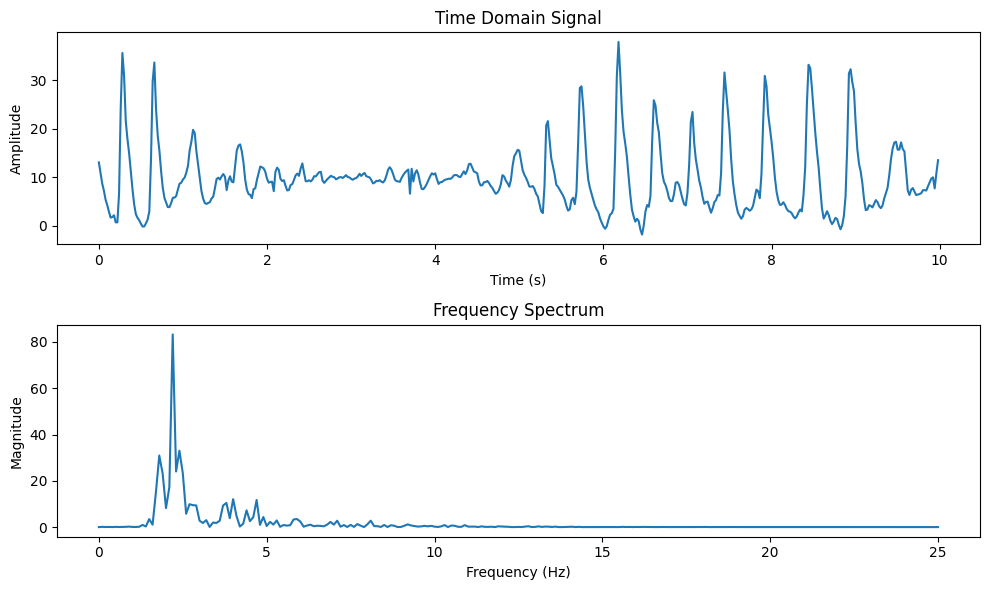

In [66]:
show_spectrum(acce_z[:500], fs=50)

# Find the fundamental frequency and its harmonics
frequencies, spectrum = scipy.signal.periodogram(acce_z[:500], fs=50)
harmonics = [2, 3, 4]
(
    fundamental_frequency,
    amplitude,
    harmonics_found,
) = find_fundamental_frequency_and_harmonics(frequencies, spectrum, harmonics)

print(
    f"Fundamental Frequency: {fundamental_frequency} Hz, Magnitude: {amplitude:.2f}"
)
print(f"Harmonics Found: {harmonics_found}")

In [67]:
def find_fx_fy(path_acce_data, verbose=False):
  ts = path_acce_data[:, 0]
  ax = path_acce_data[:, 1]
  ay = path_acce_data[:, 2]
  az = path_acce_data[:, 3]

  sampling_period = np.mean((ts[:-1] - ts[:1]) / 1000)
  sampling_freq = 1.0 / sampling_period
  if verbose:
    print(f"sampling_period={sampling_period}, sampling_freq={sampling_freq}")

  fx, sx = scipy.signal.periodogram(ax, fs=sampling_freq)
  fy, sy = scipy.signal.periodogram(ay, fs=sampling_freq)
  fz, sz = scipy.signal.periodogram(az, fs=sampling_freq)

  ix = np.argmax(sx)
  iy = np.argmax(sy)
  iz = np.argmax(sz)
  funda_fx, funda_sx = fx[ix], sx[ix]
  funda_fy, funda_sy = fy[iy], sy[iy]
  funda_fz, funda_sz = fz[iz], sz[iz]

  # Finding components parallel to movement
  # Finding the frequency associated with largest amplitude
  funda_s = np.max([funda_sx, funda_sy, funda_sz])
  if funda_s == funda_sz:
    funda_idx = iz
  elif funda_s == funda_sy:
    funda_idx = iy
  else:
    funda_idx = ix

  if verbose:
    print(
        f"fx={funda_fx}, amp_x={funda_sx}, fy={funda_fy}, amp_y={funda_sy}, fz={funda_fz}, amp_z={funda_sz}"
    )

  # Finding the magnitude of the second harmonic
  h2_sx, h2_sy, h2_sz = sx[funda_idx * 2], sy[funda_idx * 2], sz[funda_idx * 2]

  # Finding two components which are most likely to be parallel to movement
  h2_min = np.min([h2_sx, h2_sy, h2_sz])
  if h2_min == h2_sx:
    ans_fx, ans_fy = h2_sy, h2_sz
  elif h2_min == h2_sy:
    ans_fx, ans_fy = h2_sz, h2_sx
  else:
    ans_fx, ans_fy = h2_sx, h2_sy

  return ans_fx, ans_fy


In [68]:
fx, fy = find_fx_fy(path_datas.acce, verbose=True)

sampling_period=123.82332699863684, sampling_freq=0.008076022702983977
fx=0.0001463422972157135, amp_x=8590.930979158104, fy=1.295064577130208e-06, amp_y=38471.97122618802, fz=0.00029980744960564316, amp_z=467052.8431722102


In [69]:
np.degrees(np.arctan(fy / fx))

89.52128494356998

* Next, we try a different approach to find `Fx` (the magnitude of the second harmonic in the Fourier transform along the West) and `Fy` (the magnitude of the second harmonic in the Fourier transform along the North).
  * We map the acceleration vector to the Earth coordinate system, in which x-axis points East, y-axis points North and z-axis points to the sky.
  * Then `Fx = -(F along the x-axis)`, `Fy = F along the y axis`

In [70]:
parallel = np.linalg.norm(acce_earths[:, :2], axis=1)
perpendicular = acce_earths[:, 2]

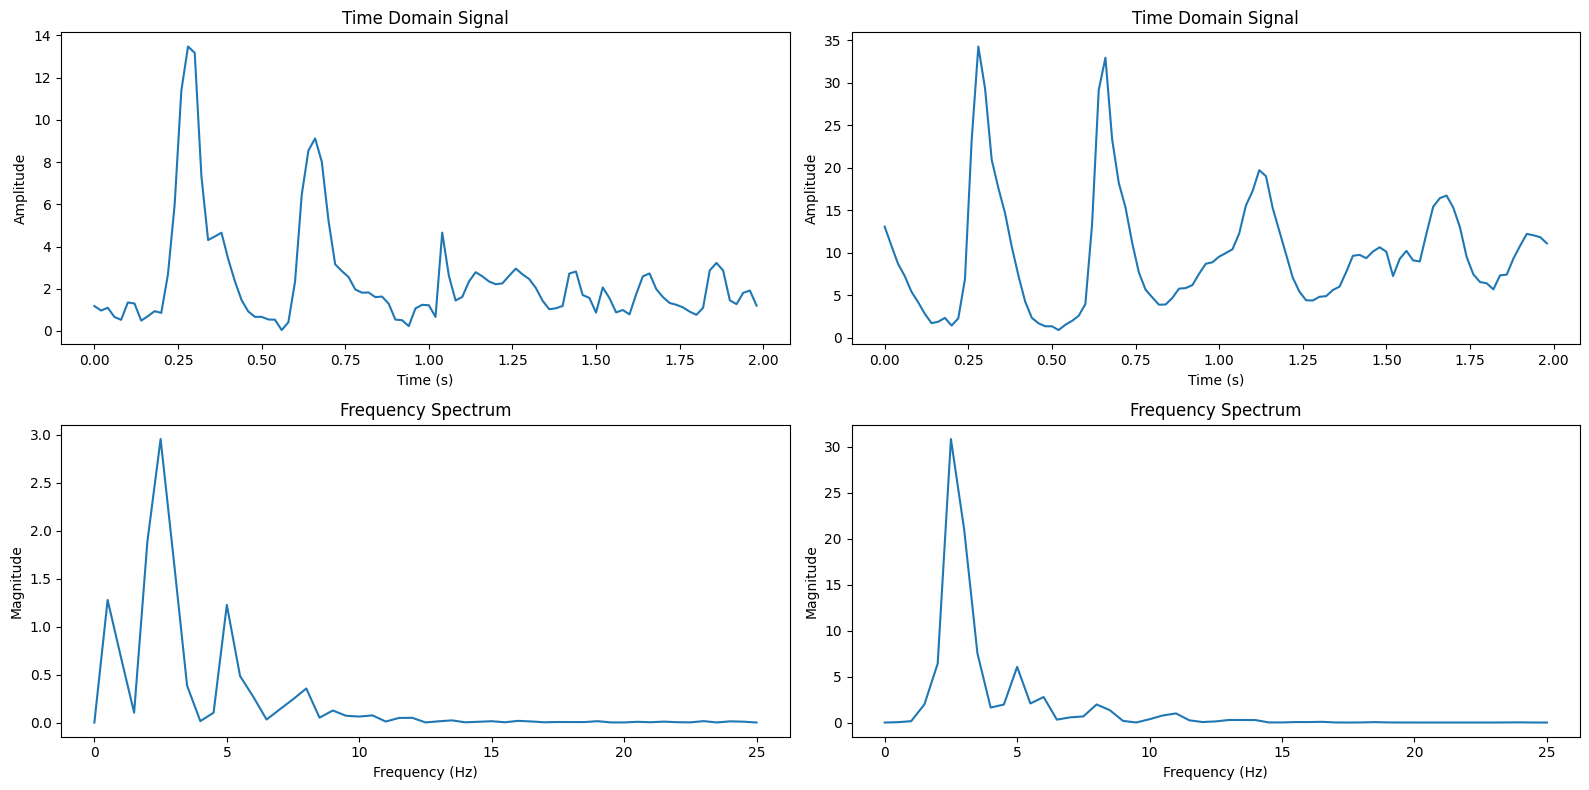

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

show_spectrum(parallel[:100], fs=50, ax1=axes[0][0], ax2=axes[1][0])
show_spectrum(perpendicular[:100], fs=50, ax1=axes[0][1], ax2=axes[1][1])

plt.show()

In [72]:
def estimate_heading_offset(acce_earths, fs):
  parallel = np.linalg.norm(acce_earths[:, :2], axis=1)
  f_parallel, amp_parallel = scipy.signal.periodogram(parallel, fs=fs)
  idx = np.argmax(amp_parallel)
  fx = -1 * acce_earths[idx * 2, 0]
  fy = acce_earths[idx * 2, 1]

  return np.degrees(np.arctan(fx / fy))

In [73]:
estimate_heading_offset(acce_earths[:100], fs=50)

-87.4769082144529

### Magnetic Offsets

* Heading computation from ground-truth location

In [75]:
gt_x = gt_location[:, 0]
gt_y = gt_location[:, 1]

gt_heading_values = np.degrees(
    np.arctan((gt_y[1:] - gt_y[:-1]) / (gt_x[1:] - gt_x[:-1])))


In [76]:
ts = path_datas.acce[:, 0]
min_time, max_time, n_samples = ts.min(), ts.max(), len(ts)

In [77]:
gt_ts = path_datas.waypoint[:-1, 0]
gt_ts_frac = (gt_ts - min_time) / (max_time - min_time) * n_samples
gt_ts_frac = np.rint(np.clip(gt_ts_frac, a_min=0, a_max=n_samples)).astype(np.int64)

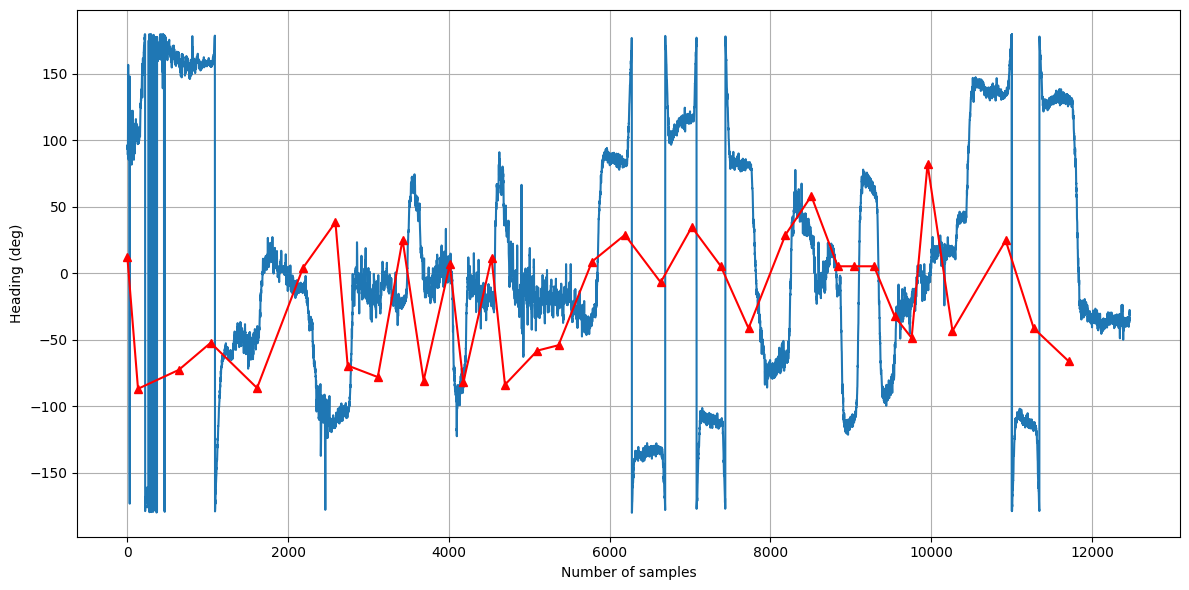

In [78]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

ax.plot(heading_values, label="heading")
ax.plot(gt_ts_frac, gt_heading_values, marker="^", color="red", label="ground-truth")
ax.set_ylabel("Heading (deg)")
ax.set_xlabel("Number of samples")
ax.grid()

plt.tight_layout()
plt.show()

* We have to rotate the original coordinate system into a coordinate system in which `Ox` points North.
* The equation for rotation could be found here: https://en.wikipedia.org/wiki/Rotation_of_axes_in_two_dimensions

In [81]:
def rotate(xs, ys, a):
  xs = np.atleast_1d(xs)
  ys = np.atleast_1d(ys)

  r_xs = xs * np.cos(a) + ys * np.sin(a)
  r_ys = -1 * xs * np.sin(a) + ys * np.cos(a)

  return r_xs, r_ys


# sanity check
r_xs, r_ys = rotate(np.sqrt(3), 1, np.pi / 6)
assert np.isclose(r_xs[0], 2)
assert np.isclose(r_ys[0], 0)

r_xs, r_ys = rotate(7, 7, -np.pi / 2)
assert np.isclose(-7, r_xs[0])
assert np.isclose(7, r_ys[0])

In [82]:
# TODO: Rotation angle estimation using multiple data points

gt_x = gt_location[:, 0]
gt_y = gt_location[:, 1]

k1 = (gt_y[1] - gt_y[0]) / (gt_x[1] - gt_x[0])
k2 = np.tan(np.radians(heading_values[0]))

rotation_angle = np.arctan((k1 - k2) / (1 + k1 * k2))
print(
    f"rotation_angle: {rotation_angle:.2f} (rad), {np.degrees(rotation_angle):.2f} (deg)"
)

rotation_angle: -1.47 (rad), -84.05 (deg)


In [83]:
r_gt_x, r_gt_y = rotate(gt_location[:, 0], gt_location[:, 1], rotation_angle)

In [84]:
r_gt_heading_values = np.degrees(
    np.arctan((r_gt_y[1:] - r_gt_y[:-1]) / (r_gt_x[1:] - r_gt_x[:-1])))
r_gt_heading_values = (r_gt_heading_values + 180) % 180  # avoid obstue angle

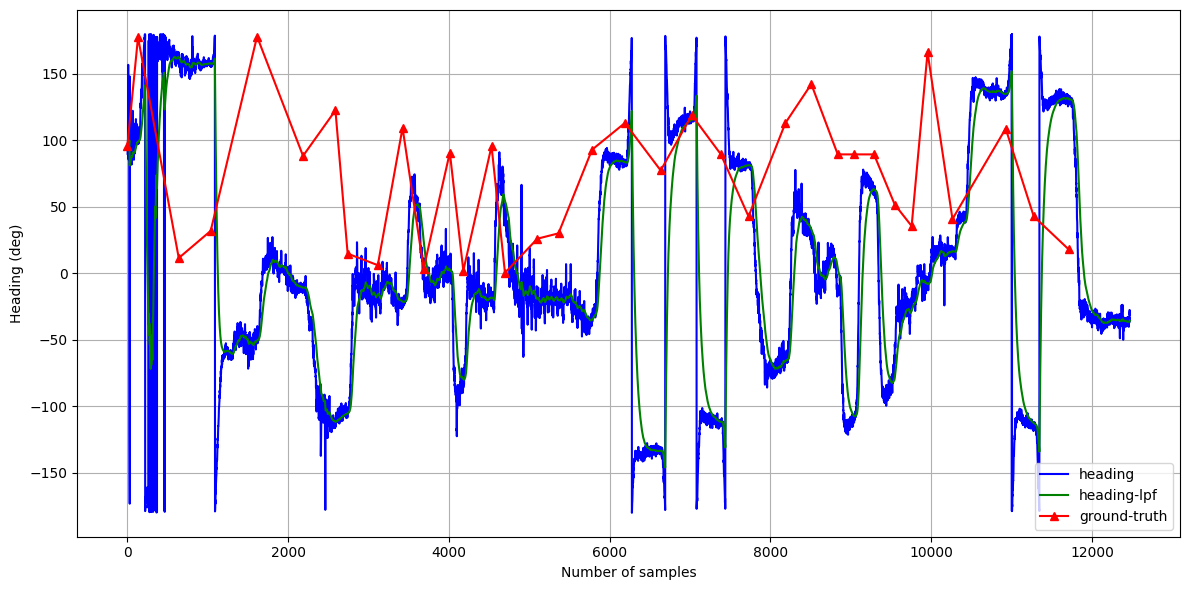

In [85]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

ax.plot(heading_values, label="heading", color="blue")
ax.plot(low_pass_filter(heading_values, 0.98), label="heading-lpf", color="green")
ax.plot(gt_ts_frac, r_gt_heading_values, marker="^", color="red", label="ground-truth")
ax.set_ylabel("Heading (deg)")
ax.set_xlabel("Number of samples")
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

## Augmented Particle Filter

### Map Data Preprocessing

In [86]:
def transform_rotation(rotation_angle):

  def impl(coords):
    r_xs, r_ys = rotate(coords[:, 0], coords[:, 1], rotation_angle)
    return np.vstack((r_xs, r_ys)).T

  return impl


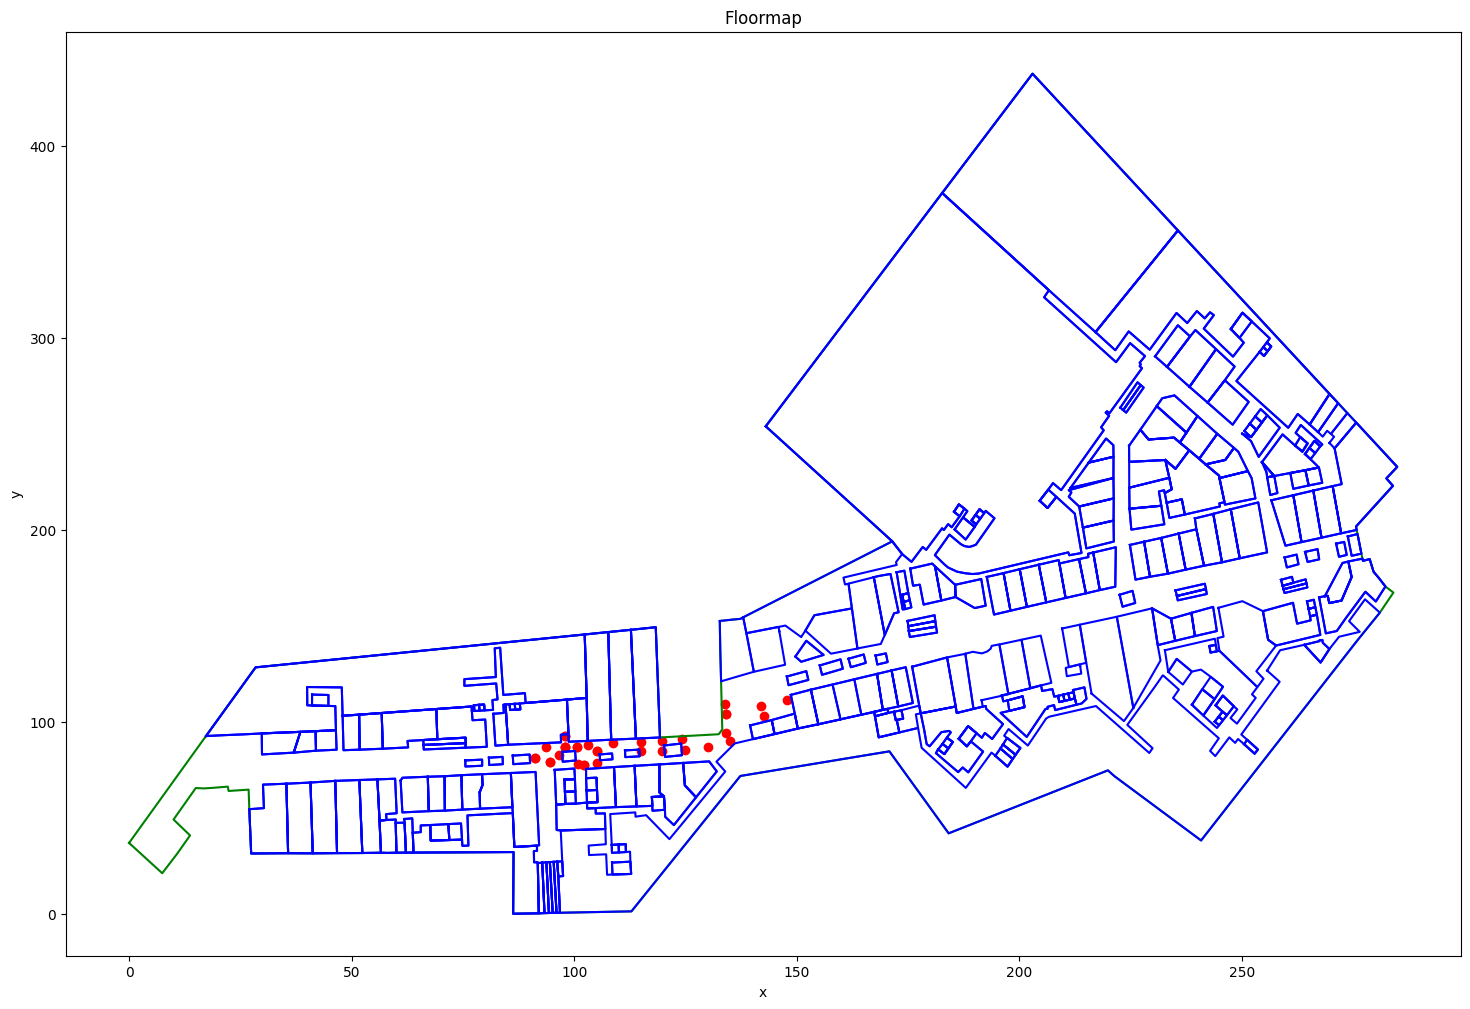

In [89]:
transform_func = transform_rotation(rotation_angle)
(
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
    x, y = floor_polygon.exterior.xy
    ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
    x, y = store_polygon.exterior.xy
    ax.plot(x, y, color="blue", label="store")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding ground-truth location
r_gt_location = transform_func(gt_location)
scale(
    r_gt_location, x_min, y_min, x_max, y_max, width_meter, height_meter, inplace=True
)
ax.scatter(r_gt_location[:, 0], r_gt_location[:, 1], marker="o", color="red")

plt.ticklabel_format(useOffset=False)
plt.show()

#### Search Space Extraction

* Search space is the space occupied by the floor excluding the space occupied by the stores.

In [90]:
union_floor_polygon = shapely_ops.unary_union(floor_polygons)
union_store_polygon = shapely_ops.unary_union(store_polygons)
floor_search_space = union_floor_polygon.difference(union_store_polygon)

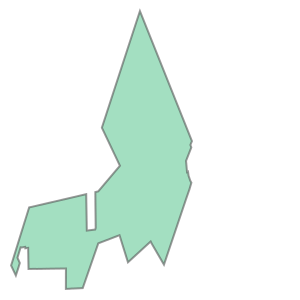

In [91]:
union_floor_polygon

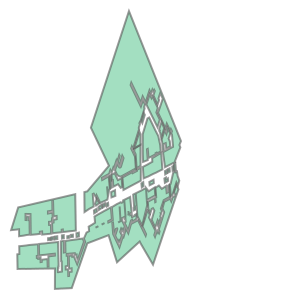

In [92]:
union_store_polygon

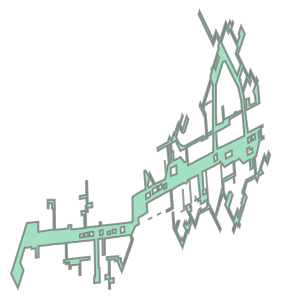

In [93]:
floor_search_space

In [94]:
# Generate search grid

grid_resolution = 2  # 5 meters
grid_xs = np.arange(0, width_meter, grid_resolution) + grid_resolution / 2
grid_ys = np.arange(0, height_meter, grid_resolution) + grid_resolution / 2

grid_x, grid_y = np.meshgrid(grid_xs, grid_ys)

In [95]:
search_space_mask = shapely.vectorized.contains(floor_search_space, grid_x, grid_y)
ss_x, ss_y = grid_x[search_space_mask], grid_y[search_space_mask]

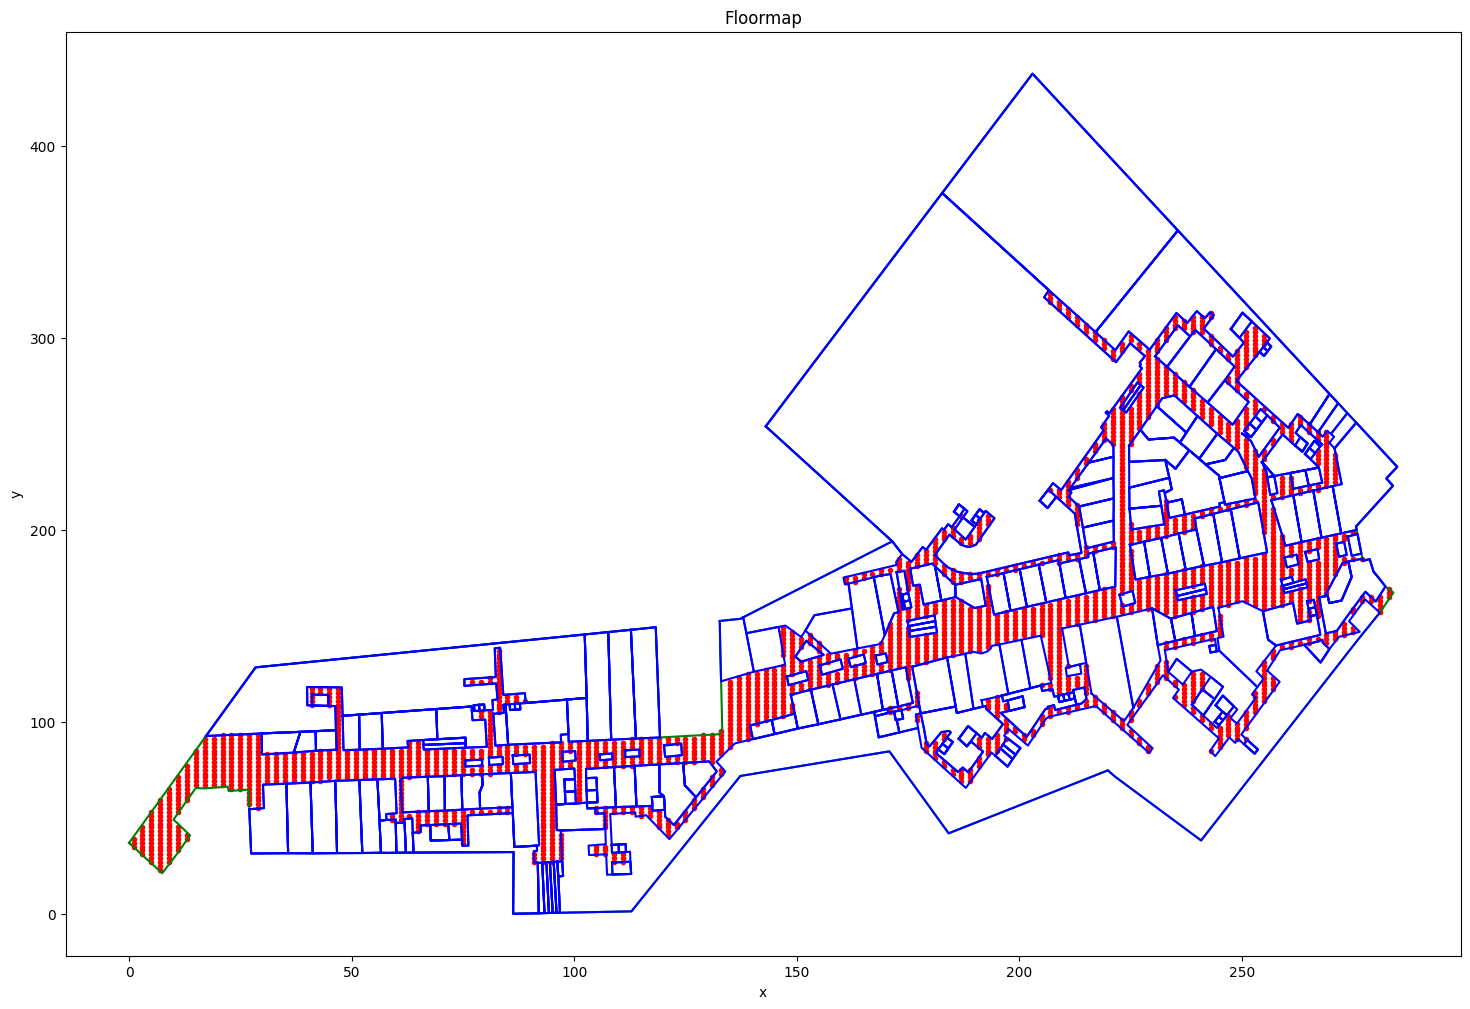

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue", label="store")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding search grid
ax.scatter(ss_x, ss_y, marker=".", color="red", label="ss")

plt.ticklabel_format(useOffset=False)
plt.show()

In [109]:
ss_y.shape[0]

2494

In [ ]:
# TODO: using NN to identify valid particle

In [110]:
from sklearn.neighbors import NearestNeighbors

In [116]:
X_ss = np.vstack((ss_x, ss_y)).T

In [122]:
nn = NearestNeighbors(n_neighbors=5, radius=5, algorithm="ball_tree")

In [123]:
_ = nn.fit(X_ss)

In [124]:
distance, indices = nn.kneighbors(particles[:, :2], n_neighbors=1)

### Implementation of APF

In [98]:
@dataclass
class APFStep(object):
  particles: np.ndarray
  parent: np.ndarray
  sample_index: int
  children: np.ndarray | None = None

In [140]:
# Initialization

ss_n = len(ss_x)
n_particles = 100000

# Range for stride length
stride_length_min, stride_length_max = 0.5, 1.2

particles = np.zeros((n_particles, 4), dtype=np.float64)
weights = np.ones(n_particles) / n_particles

# Initial random position
ss_idx = np.random.randint(ss_n, size=n_particles)
particles[:, 0] = ss_x[ss_idx]
particles[:, 1] = ss_y[ss_idx]

# Initial random stride length
particles[:, 2] = np.random.uniform(
    stride_length_min, stride_length_max, size=n_particles
)

# Initial placement offset
heading_offset = estimate_heading_offset(acce_earths[:1], fs=50)
heading = heading_values[0]
alpha = heading_offset - heading
placement_offsets_1 = np.random.normal(alpha, 10, size=n_particles//2)
placement_offsets_2 = np.random.normal(alpha + 180, 10, size=n_particles//2)
particles[:, 3] = np.hstack((placement_offsets_1, placement_offsets_2))
np.random.shuffle(particles[:, 3])

In [141]:
acce = np.sqrt(np.sum(path_datas.acce[:, 1:] ** 2, axis=1))

turn_delta_heading = 20  # 20 degrees
magnetic_offset_error_scale = 5   # 5 degrees
stride_length_variation = 0.1   # 10 percents

step_idx = 0
it = 0
prev_state = None
prev_t_opt = None
particle_indices = np.arange(n_particles)

# eliminated = true if the particle was eliminated in the next step, false otherwise
parent = np.ones(n_particles, dtype=np.int32) * -1
history = [
  APFStep(particles=particles, parent=parent, sample_index=0)
]

while True:
  it += 1

  if (prev_t_opt is not None) and (step_idx + 2 * prev_t_opt >= len(acce)):
    break

  state, t_opt = get_state(
    acce, m=step_idx, prev_state=prev_state, prev_t_opt=prev_t_opt
  )

  step_freq = t_opt // 2
  next_step_idx = step_idx + step_freq

  print(
    f"Iteration {it}: state = {state}, step_freq = {step_freq} samples/step, sample_idx = {step_idx} -> {next_step_idx}"
  )

  if state == "WALKING":
    last_apf_step = history[-1]

    last_particles = last_apf_step.particles.copy()
    particles = last_particles.copy()
    parent = particle_indices.copy()
    
    # Update
    magnetic_offset = np.random.normal(loc=0, scale=np.radians(magnetic_offset_error_scale), size=n_particles)
    stride_length = particles[:, 2] + np.random.uniform(-stride_length_variation, stride_length_variation, size=n_particles) * particles[:, 2]

    # Predict with fractional update if possible
    turn_points = []
    for i in range(step_idx + 1, next_step_idx):
      if np.abs(heading_values[i] - heading_values[i - 1]) > turn_delta_heading:
        turn_points.append(i)

    if len(turn_points) == 0:
      # No fractional update
      heading = np.radians(heading_values[step_idx:next_step_idx].mean())
      angle = particles[:, 3] + heading + magnetic_offset
      particles[:, 0] = particles[:, 0] + stride_length * np.cos(angle)
      particles[:, 1] = particles[:, 1] + stride_length * np.sin(angle)
    else:
      # Fractional update
      turn_points = [step_idx, *turn_points, next_step_idx]
      for i, j in zip(turn_points[:-1], turn_points[1:]):
        heading = np.radians(heading_values[i:j].mean())
        angle = particles[:, 3] + heading + magnetic_offset
        particles[:, 0] = particles[:, 0] + stride_length * (j - i) / step_freq * np.cos(angle)
        particles[:, 1] = particles[:, 1] + stride_length * (j - i) / step_freq * np.sin(angle)

    # Resampling
    # 1/ In order to replace each eliminated particle, a new particle is randomly chosen from the particle set at the previous step AND updated.
    # 2/ To enable traceback, each particle after the k-th step maintains a link to its parent particle
    particle_mask = shapely.vectorized.contains(floor_search_space, particles[:, 0], particles[:, 1])
    n_eliminated = np.count_nonzero(~particle_mask)
    
    n_tries = 0
    while n_eliminated > 0:
      n_tries += 1

      if n_tries > 10:
        break
      
      parent[~particle_mask] = np.random.choice(particle_indices, size=n_eliminated)
      particles[~particle_mask] = last_particles[parent[~particle_mask]]

      magnetic_offset = np.random.normal(loc=0, scale=np.radians(magnetic_offset_error_scale), size=n_eliminated)
      stride_length = particles[~particle_mask, 2] * (1 + np.random.uniform(-stride_length_variation, stride_length_variation, size=n_eliminated))

      turn_points = []
      for i in range(step_idx + 1, next_step_idx):
        if np.abs(heading_values[i] - heading_values[i - 1]) > turn_delta_heading:
          turn_points.append(i)

      if len(turn_points) == 0:
        # No fractional update
        heading = np.radians(heading_values[step_idx:next_step_idx].mean())
        angle = particles[~particle_mask, 3] + heading + magnetic_offset
        particles[~particle_mask, 0] = particles[~particle_mask, 0] + stride_length * np.cos(angle)
        particles[~particle_mask, 1] = particles[~particle_mask, 1] + stride_length * np.sin(angle)
      else:
        # Fractional update
        turn_points = [step_idx, *turn_points, next_step_idx]
        for i, j in zip(turn_points[:-1], turn_points[1:]):
          heading = np.radians(heading_values[i:j].mean())
          angle = particles[~particle_mask, 3] + heading + magnetic_offset
          particles[~particle_mask, 0] = particles[~particle_mask, 0] + stride_length * (j - i) / step_freq * np.cos(angle)
          particles[~particle_mask, 1] = particles[~particle_mask, 1] + stride_length * (j - i) / step_freq * np.sin(angle)

      # This method is time consuming
      dists, indices = nn.kneighbors(particles[:, :2], n_neighbors=1)
      particle_mask = dists[:, 0] < grid_resolution
      n_eliminated = np.count_nonzero(~particle_mask)

    # Append history
    history.append(APFStep(particles=particles, parent=parent, sample_index=next_step_idx))

  prev_state = state
  prev_t_opt = t_opt
  step_idx = next_step_idx

Iteration 1: state = None, step_freq = 20 samples/step, sample_idx = 0 -> 20
Iteration 2: state = WALKING, step_freq = 25 samples/step, sample_idx = 20 -> 45
Iteration 3: state = WALKING, step_freq = 21 samples/step, sample_idx = 45 -> 66
Iteration 4: state = WALKING, step_freq = 23 samples/step, sample_idx = 66 -> 89
Iteration 5: state = WALKING, step_freq = 26 samples/step, sample_idx = 89 -> 115
Iteration 6: state = WALKING, step_freq = 26 samples/step, sample_idx = 115 -> 141
Iteration 7: state = WALKING, step_freq = 21 samples/step, sample_idx = 141 -> 162
Iteration 8: state = WALKING, step_freq = 21 samples/step, sample_idx = 162 -> 183
Iteration 9: state = WALKING, step_freq = 24 samples/step, sample_idx = 183 -> 207
Iteration 10: state = WALKING, step_freq = 29 samples/step, sample_idx = 207 -> 236
Iteration 11: state = WALKING, step_freq = 32 samples/step, sample_idx = 236 -> 268
Iteration 12: state = WALKING, step_freq = 32 samples/step, sample_idx = 268 -> 300
Iteration 13: 

In [142]:
# Backward belief propagation

last_idx = len(history) - 1
last_parent = history[last_idx].parent
history[last_idx].has_children = np.array([True] * n_particles)

while last_idx > 0:
  last_idx -= 1
  history[last_idx].has_children = np.array([False] * n_particles)
  history[last_idx].has_children[last_parent] = True

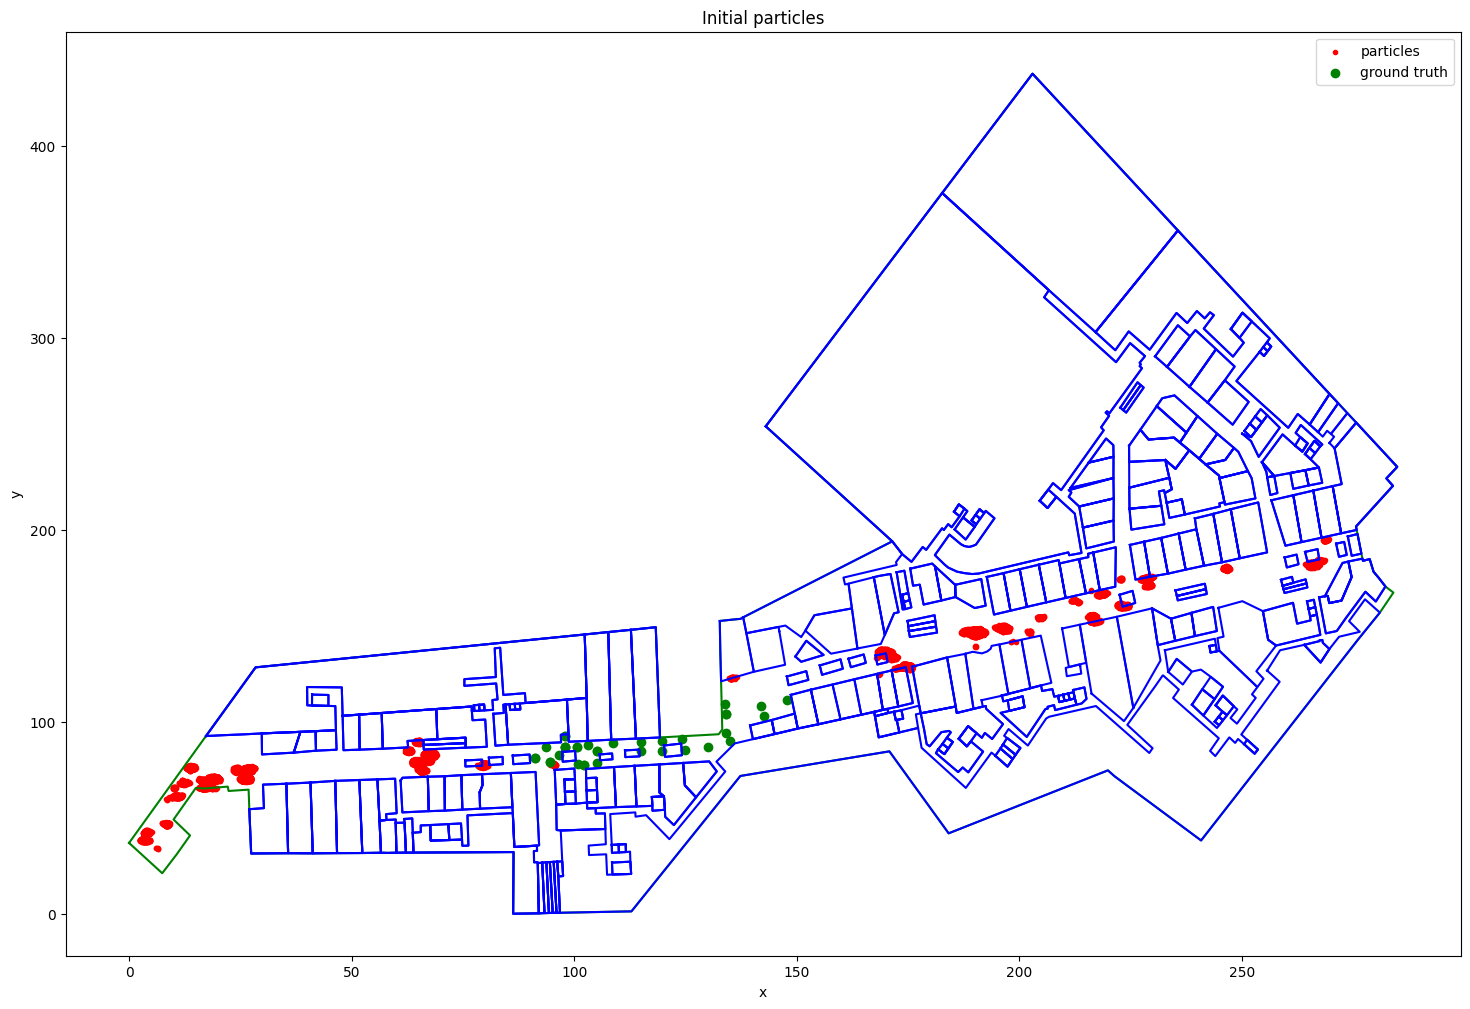

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
    x, y = floor_polygon.exterior.xy
    ax.plot(x, y, color="green")

for store_polygon in store_polygons:
    x, y = store_polygon.exterior.xy
    ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Initial particles")

particles    = history[150].particles
has_children = history[150].has_children

ax.scatter(
    particles[has_children][:, 0],
    particles[has_children][:, 1],
    marker=".",
    color="red",
    label="particles",
)
ax.scatter(
    r_gt_location[:, 0],
    r_gt_location[:, 1],
    marker="o",
    color="green",
    label="ground truth",
)

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

#### Result Reporting

* Given particle history, report the localization result.